In [1]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gmaps

In [2]:
#Read CSV file, convert to dataframe
drg_master = pd.read_csv('data/Inpatient_PYMT_IPPS_DRG_FY2017_CLEAN.csv')
centroids = pd.read_csv('data/state_centroids.csv')
census_master = pd.read_csv('data/state_census_data.csv')
centroids.head(2)

,State,State_Abb,Latitude,Longitude
0,Alabama,AL,32.7794,-86.8287
1,Alaska,AK,64.0685,-152.2782


In [3]:
#Cleanup Column Names
drg_master = drg_master.rename(columns={'DRG Definition': 'DRG', 'Provider Name': 'Name', 'Provider City': 'City',
                                       'Provider State': 'State', 'Provider Zip Code': 'Zip Code',
                                       'Hospital Referral Region (HRR) Description': 'Region', 'Total Discharges': 'Discharges',
                                       'Average Covered Charges': 'List Price', 'Average Total Payments': 'Average Total',
                                       'Average Medicare Payments': 'Average Medicare'})
drg_master.head(2)

,DRG,Provider Id,Name,Provider Street Address,City,State,Zip Code,Region,Discharges,List Price,Average Total,Average Medicare
0,291 - HEART FAILURE & SHOCK W MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,371,34642.05,7771.63,6965.86
1,291 - HEART FAILURE & SHOCK W MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,89,18208.90,8220.40,6905.46


In [4]:
#Data Munging - add Centroid coordinates by state level

drg_master['Latitude']=''
drg_master['Longitude']=''
drg_master['Per Capita Income']= ''
drg_master['Poverty Rate']=''
drg_master['Median Age']=''

for i in range(len(drg_master)):    
        
    for j in range (len(centroids)):
        if str(centroids.iloc[j]['State_Abb']) == str(drg_master.iloc[i]['State']):
            drg_master.ix[i, 'Latitude'] = centroids.iloc[j]['Latitude']
            drg_master.ix[i, 'Longitude'] = centroids.iloc[j]['Longitude']
        if str(census_master.iloc[j]['State']) == str(drg_master.iloc[i]['State']):
            try:
                drg_master.ix[i, 'Per Capita Income'] = census_master.iloc[j]['Per Capita Income']
                drg_master.ix[i, 'Poverty Rate'] = census_master.iloc[j]['Poverty Rate']
                drg_master.ix[i, 'Median Age'] = census_master.iloc[j]['Median Age']
            except (KeyError, IndexError):
                drg_master.ix[i, 'Per Capita Income'] = ''
                drg_master.ix[i, 'Poverty Rate'] = ''
                drg_master.ix[i, 'Median Age'] = ''
drg_master.head()

C:\Users\fireh\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]
C:\Users\fireh\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  
C:\Users\fireh\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
C:\Users\fireh\Anaconda3\env

,DRG,Provider Id,Name,Provider Street Address,City,State,Zip Code,Region,Discharges,List Price,Average Total,Average Medicare,Latitude,Longitude,Per Capita Income,Poverty Rate,Median Age
0,291 - HEART FAILURE & SHOCK W MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,371,34642.05,7771.63,6965.86,32.7794,-86.8287,23680,18.1409,38.1
1,291 - HEART FAILURE & SHOCK W MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,89,18208.90,8220.40,6905.46,32.7794,-86.8287,23680,18.1409,38.1
2,291 - HEART FAILURE & SHOCK W MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,238,33568.66,7310.01,6292.20,32.7794,-86.8287,23680,18.1409,38.1
3,291 - HEART FAILURE & SHOCK W MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,148,44123.34,8488.86,7244.08,32.7794,-86.8287,23680,18.1409,38.1
4,291 - HEART FAILURE & SHOCK W MCC,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,AL - Birmingham,32,54984.84,8317.91,7620.53,32.7794,-86.8287,23680,18.1409,38.1


In [5]:
drg_master.to_csv('drg_updated.csv',encoding='utf-8')

In [6]:
#Hive off Diabetes and Joint Replacement procedures to new dataframes
diabetes_master = drg_master.loc[drg_master['DRG'] == '638 - DIABETES W CC']
joint_master = drg_master.loc[drg_master['DRG'] == '470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT OF LOWER EXTREMITY W/O MCC']

#Create average and st_dev dataframes, sorted by descending
diabetes_stdev = diabetes_master.groupby('State').std().drop(['Provider Id', 'Zip Code', 'Discharges'],axis=1)
diabetes_avgtotal = diabetes_master.groupby('State').mean().dropna()

joint_avgtotal = joint_master.groupby('State').mean().dropna()
joint_stdev = joint_master.groupby('State').std().drop(['Provider Id', 'Zip Code', 'Discharges'],axis=1)

#Print Joint Std_Dev sorted by List Price (covered charges)
#joint_stdev.sort_values(by=['Average Total'], ascending=False)


In [7]:
#Print Diabetes Std_Dev sorted by List Price (covered charges)
diabetes_stdev.sort_values(by=['List Price'], ascending=False)

,List Price,Average Total,Average Medicare,Per Capita Income
State,,,,
NJ,20505.761289,1576.911330,1175.678073,0.0
CA,18309.857682,2520.417512,2369.803427,0.0
PA,16235.911976,1842.524003,1152.329736,0.0
MS,15839.056195,890.558820,768.308840,0.0
AL,15274.962317,693.668359,465.921945,0.0
NY,15009.995636,3086.944511,2724.370676,0.0
NV,14676.158146,1546.988530,1322.550379,0.0
FL,14111.461349,1598.145099,1162.311862,0.0
TX,13091.000988,1773.754223,1417.593893,0.0


In [8]:
#More Data Munging - add Centroid coordinates by state level, re-add to St_Dev and Average group-by dataframes

joint_stdev.reset_index(level=0, inplace=True)
joint_avgtotal.reset_index(level=0, inplace=True)
diabetes_stdev.reset_index(level=0, inplace=True)
diabetes_avgtotal.reset_index(level=0, inplace=True)
joint_stdev['Latitude']=''
joint_avgtotal['Longitude']=''
diabetes_stdev['Latitude']=''
diabetes_avgtotal['Longitude']=''

for i in range(len(centroids)):    
        
    for j in range (len(centroids)):
        if str(centroids.iloc[j]['State_Abb']) == str(joint_stdev.iloc[i]['State']):
            joint_stdev.ix[i, 'Latitude'] = centroids.iloc[j]['Latitude']
            joint_stdev.ix[i, 'Longitude'] = centroids.iloc[j]['Longitude']
        if str(centroids.iloc[j]['State_Abb']) == str(joint_avgtotal.iloc[i]['State']):
            joint_avgtotal.ix[i, 'Latitude'] = centroids.iloc[j]['Latitude']
            joint_avgtotal.ix[i, 'Longitude'] = centroids.iloc[j]['Longitude']
        if str(centroids.iloc[j]['State_Abb']) == str(diabetes_stdev.iloc[i]['State']):
            diabetes_stdev.ix[i, 'Latitude'] = float(centroids.iloc[j]['Latitude'])
            diabetes_stdev.ix[i, 'Longitude'] = float(centroids.iloc[j]['Longitude'])
        if str(centroids.iloc[j]['State_Abb']) == str(diabetes_avgtotal.iloc[i]['State']):
            diabetes_avgtotal.ix[i, 'Latitude'] = float(centroids.iloc[j]['Latitude'])
            diabetes_avgtotal.ix[i, 'Longitude'] = float(centroids.iloc[j]['Longitude'])

C:\Users\fireh\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()
C:\Users\fireh\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
C:\Users\fireh\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
C:\Users\fireh\Anacon

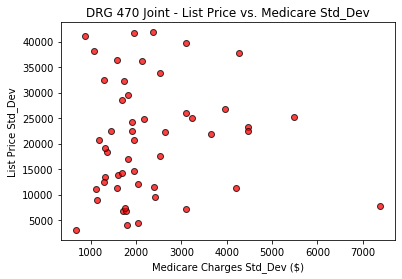

In [9]:
# Joints - Create Matplotlib scatter based on Std_Dev List Price vs. Avg Medicare
plt.title("DRG 470 Joint - List Price vs. Medicare Std_Dev")
plt.xlabel('Medicare Charges Std_Dev ($)')
plt.ylabel('List Price Std_Dev')
plt.scatter(joint_stdev['Average Medicare'],joint_stdev['List Price'], marker="o", facecolors="red", edgecolors="black",alpha=0.75)
plt.savefig('data/drg470joint_list_medicare.png')

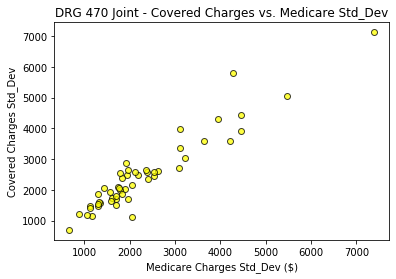

In [10]:
# Joints - Create Matplotlib scatter based on Std_Dev Avg Total vs. Avg Medicare
plt.title("DRG 470 Joint - Covered Charges vs. Medicare Std_Dev")
plt.xlabel('Medicare Charges Std_Dev ($)')
plt.ylabel('Covered Charges Std_Dev')
plt.scatter(joint_stdev['Average Medicare'],joint_stdev['Average Total'], marker="o", facecolors="yellow", edgecolors="black",alpha=0.75)
plt.savefig('data/drg470joint_covered_medicare.png')

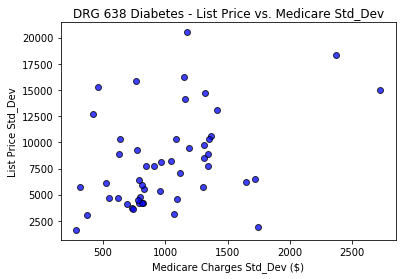

In [11]:
# Diabetes - Create Matplotlib scatter based on Std_Dev List Price vs. Avg Medicare
plt.title("DRG 638 Diabetes - List Price vs. Medicare Std_Dev")
plt.xlabel('Medicare Charges Std_Dev ($)')
plt.ylabel('List Price Std_Dev')
plt.scatter(diabetes_stdev['Average Medicare'],diabetes_stdev['List Price'], marker="o", facecolors="blue", edgecolors="black",alpha=0.75)
plt.savefig('data/drg638diabetes_list_medicare.png')

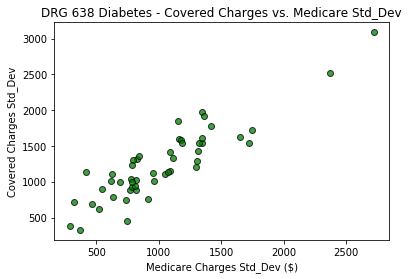

In [12]:
# Diabetes - Create Matplotlib scatter based on Std_Dev Avg Total vs. Avg Medicare
plt.title("DRG 638 Diabetes - Covered Charges vs. Medicare Std_Dev")
plt.xlabel('Medicare Charges Std_Dev ($)')
plt.ylabel('Covered Charges Std_Dev')
plt.scatter(diabetes_stdev['Average Medicare'],diabetes_stdev['Average Total'], marker="o", facecolors="green", edgecolors="black",alpha=0.75)
plt.savefig('data/drg638diabetes_covered_medicare.png')

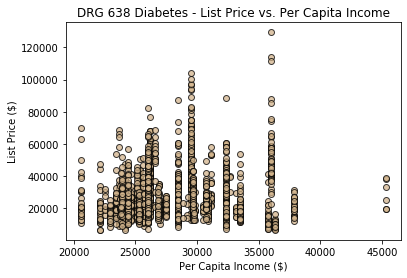

In [42]:
# Diabetes vs. Poverty Rate - Create Matplotlib scatter based on List Price vs. Poverty Rate
plt.title("DRG 638 Diabetes - List Price vs. Per Capita Income")
plt.xlabel('Per Capita Income ($)')
plt.ylabel('List Price ($)')
plt.scatter(diabetes_master['Per Capita Income'],diabetes_master['List Price'], marker="o", facecolors="tan", edgecolors="black",alpha=0.75)
plt.savefig('data/drg638diabetes_list_income.png')

In [14]:
#Examine Mississippi, Diabetes
diabetes_state_list = []
diabetes_state_medicare = []
diabetes_zipcode = []

for i in range (len(diabetes_master)):
    if diabetes_master.iloc[i]['State'] == 'MS':
        diabetes_state_list.append(diabetes_master.iloc[i]['List Price'])
        diabetes_state_medicare.append(diabetes_master.iloc[i]['Average Medicare'])
        diabetes_zipcode.append(diabetes_master.iloc[i]['City'])
diabetes_state_list.sort(reverse=True)
diabetes_state_medicare.sort(reverse=True)

No handles with labels found to put in legend.


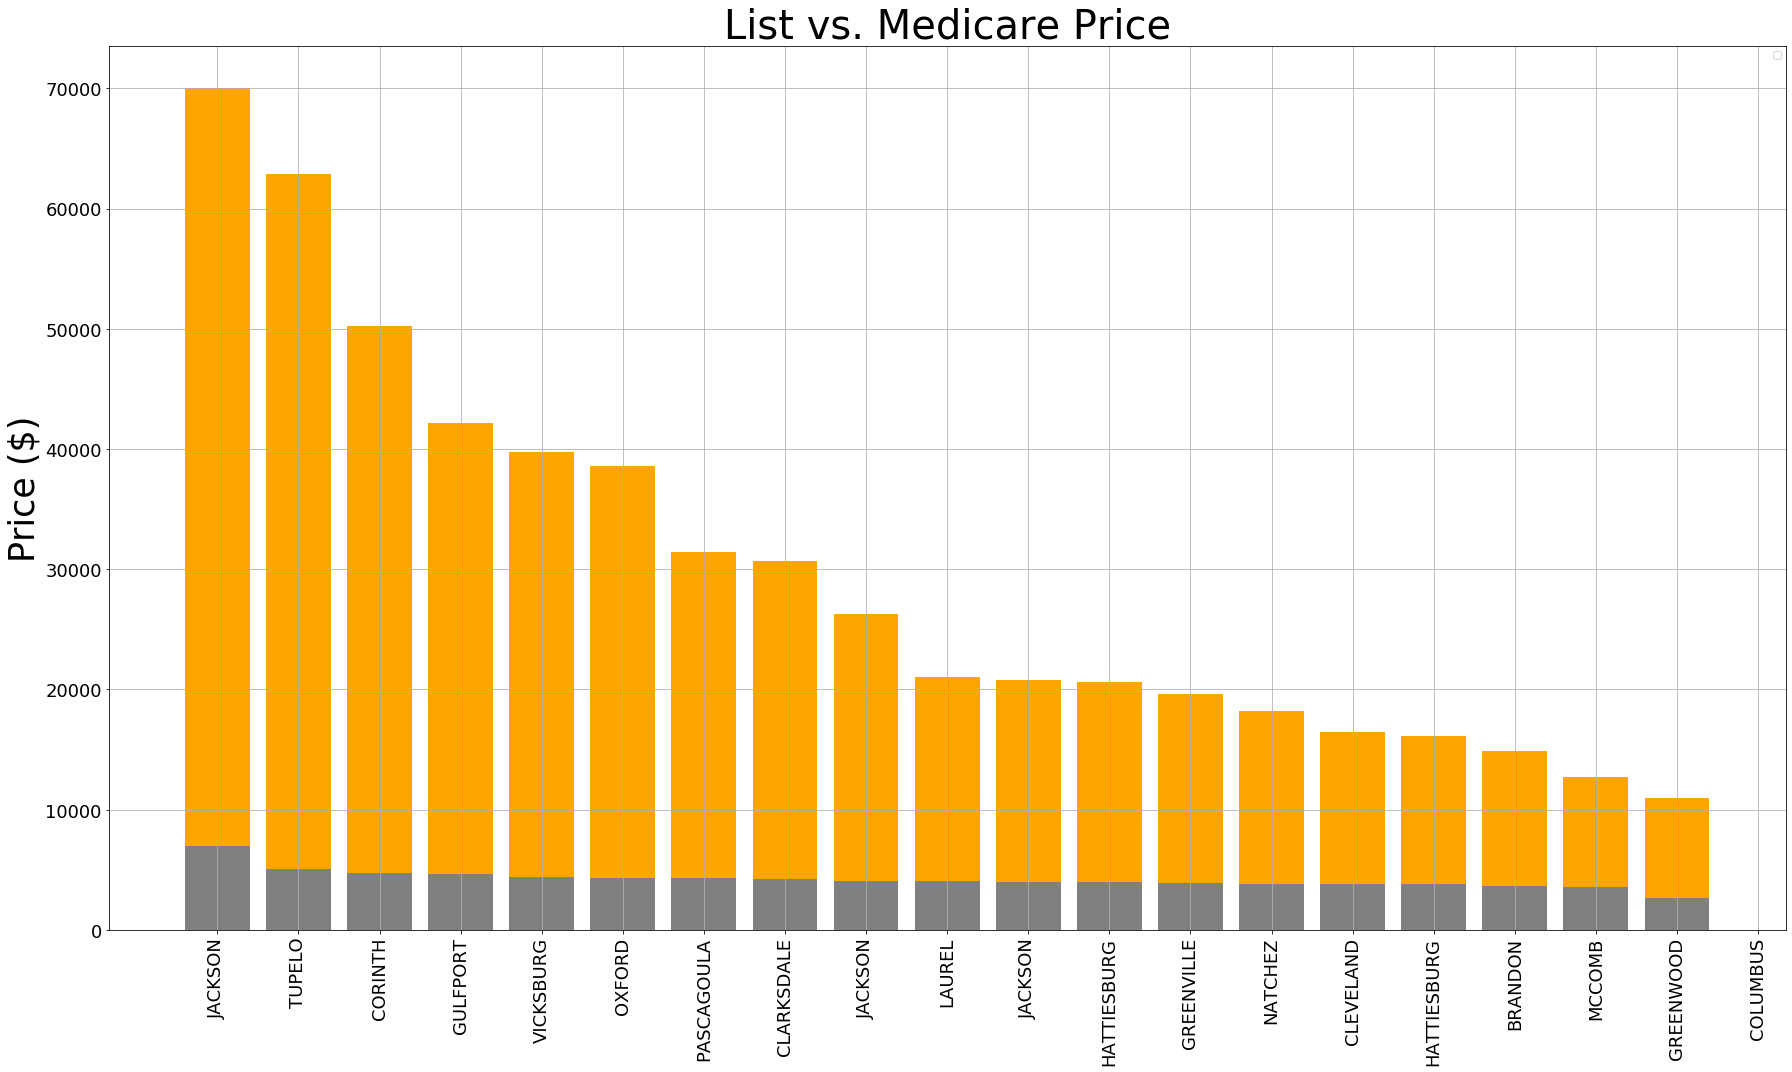

In [15]:
# Orient widths. Add labels, tick marks, etc. 
fig, ax = plt.subplots(figsize=(25,15))
x_range = np.arange(0,len(diabetes_state_list))
font = 18

tick_locations = [value for value in x_range]
plt.xticks (tick_locations, diabetes_zipcode, rotation=90, size = font)
plt.yticks (size = font)

#Plot Bar Charts
ax.bar(diabetes_zipcode, diabetes_state_list, color='orange', alpha=1, align="center")
ax.bar(diabetes_zipcode, diabetes_state_medicare, color='gray', alpha=1, align="center")

#Set Titles
plt.title("List vs. Medicare Price",size = 40)
plt.ylabel("Price ($)",size = 35)
plt.grid(True)
fig.tight_layout()
plt.legend()

In [16]:
#Examine Mississippi, Joint
joint_state_list = []
joint_state_medicare = []
joint_zipcode = []

for i in range (len(joint_master)):
    if joint_master.iloc[i]['State'] == 'MS':
        joint_state_list.append(joint_master.iloc[i]['List Price'])
        joint_state_medicare.append(joint_master.iloc[i]['Average Medicare'])
        joint_zipcode.append(joint_master.iloc[i]['City'])
        
joint_state_list.sort(reverse=True)
joint_state_medicare.sort(reverse=True)

No handles with labels found to put in legend.


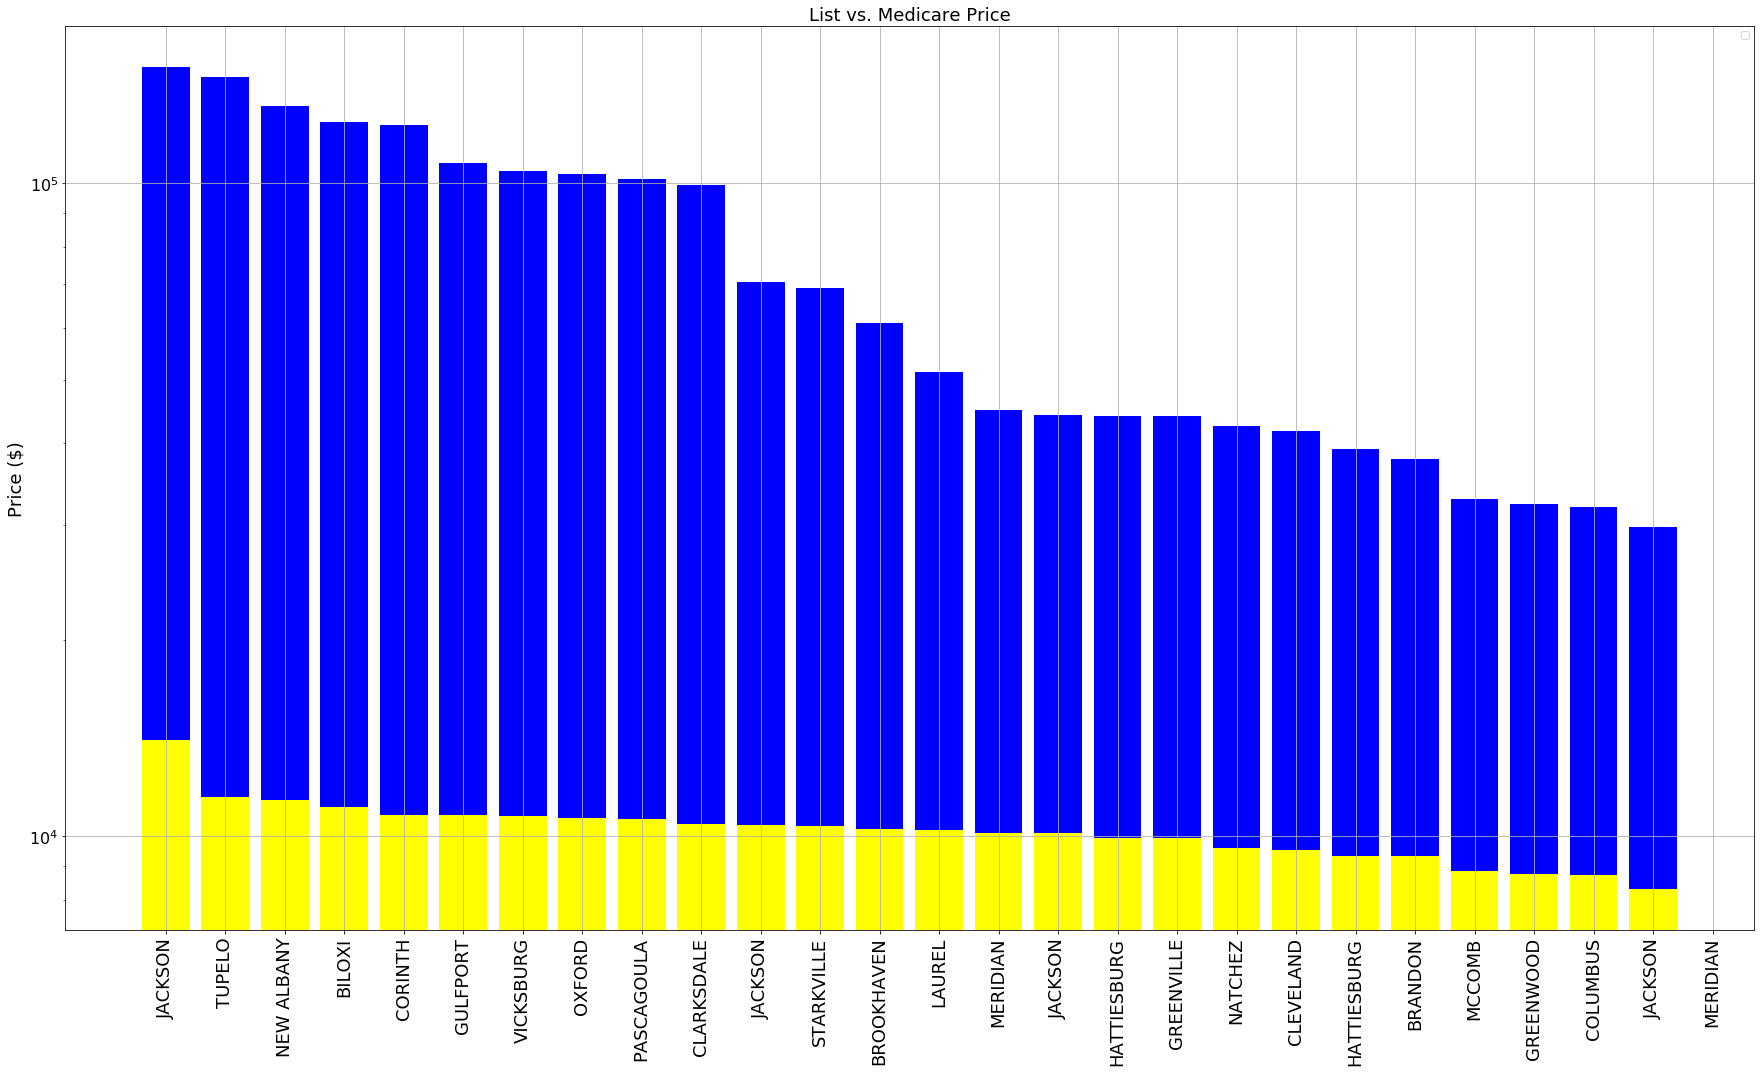

In [17]:
# Orient widths. Add labels, tick marks, etc. 
fig, ax = plt.subplots(figsize=(25,15))
x_range = np.arange(0,len(joint_state_list))
font = 18

tick_locations = [value for value in x_range]
plt.xticks (tick_locations, joint_zipcode, size = font, rotation=90)
plt.yticks (size = '16')

#Plot Bar Charts
ax.bar(joint_zipcode, joint_state_list, color='Blue', alpha=1, align="center")
ax.bar(joint_zipcode, joint_state_medicare, color='yellow', alpha=1, align="center")

#Set Titles
plt.title("List vs. Medicare Price", size = font)
plt.ylabel("Price ($)", size = font)
plt.grid(True)
plt.legend()
fig.tight_layout()
ax.set_yscale('log')

In [18]:
#GMAPS PREP - Convert st_dev dataframe Lat, Long columns to float, supporting Heatmaps 

#diabetes
diabetes_stdev.dropna(inplace=True)

m = pd.to_numeric(diabetes_stdev['Latitude'])
diabetes_stdev['Latitude'] = m

n = pd.to_numeric(diabetes_stdev['Longitude'])
diabetes_stdev['Longitude'] = n
diabetes_stdev['Latitude']

#joint
joint_stdev.dropna(inplace=True)

m = pd.to_numeric(joint_stdev['Latitude'])
joint_stdev['Latitude'] = m

n = pd.to_numeric(joint_stdev['Longitude'])
joint_stdev['Longitude'] = n

In [231]:
#gmaps.Map()

#Set Locations, Weights - can modify weights with new column
locations = diabetes_stdev[['Latitude', 'Longitude']]
weights = diabetes_stdev['List Price']

m = gmaps.figure()
m.add_layer(gmaps.heatmap_layer(locations, weights=weights, point_radius=40.0))
m

Figure(layout=FigureLayout(height='420px'))

In [20]:
#Drill into Mississippi - DIABETES
diabetes_ms = diabetes_master.loc[diabetes_master['State'] == 'MS']
diabetes_ms.sort_values(by='List Price', ascending=False)
#### OBSERVED - JACKSON, AND HATTIESBURG LARGE / SMALL REGIONS ARE OF INTEREST

,DRG,Provider Id,Name,Provider Street Address,City,State,Zip Code,Region,Discharges,List Price,Average Total,Average Medicare,Latitude,Longitude,Per Capita Income,Poverty Rate,Median Age
8892,638 - DIABETES W CC,250072,MERIT HEALTH CENTRAL,1850 CHADWICK DR,JACKSON,MS,39204,MS - Jackson,11,69990.18,5607.00,4777.18,32.7364,-89.6678,20618,21.9466,36.2
8885,638 - DIABETES W CC,250019,MEMORIAL HOSPITAL AT GULFPORT,4500 13TH STREET,GULFPORT,MS,39502,MS - Gulfport,42,62883.50,5258.81,3864.95,32.7364,-89.6678,20618,21.9466,36.2
8898,638 - DIABETES W CC,250096,MERIT HEALTH RANKIN,350 CROSSGATES BLVD,BRANDON,MS,39042,MS - Jackson,13,50234.38,4644.38,3560.46,32.7364,-89.6678,20618,21.9466,36.2
8889,638 - DIABETES W CC,250042,NORTHWEST MISSISSIPPI MEDICAL CENTER,1970 HOSPITAL DRIVE,CLARKSDALE,MS,38614,TN - Memphis,14,42190.21,5909.29,5071.29,32.7364,-89.6678,20618,21.9466,36.2
8886,638 - DIABETES W CC,250031,MERIT HEALTH RIVER REGION,2100 HWY 61 N,VICKSBURG,MS,39183,MS - Jackson,16,39734.69,5475.50,4409.75,32.7364,-89.6678,20618,21.9466,36.2
8897,638 - DIABETES W CC,250094,MERIT HEALTH WESLEY,5001 W HARDY ST,HATTIESBURG,MS,39402,MS - Hattiesburg,27,38610.89,5225.48,4030.89,32.7364,-89.6678,20618,21.9466,36.2
8904,638 - DIABETES W CC,250123,GARDEN PARK MEDICAL CENTER,15200 COMMUNITY ROAD,GULFPORT,MS,39503,MS - Gulfport,13,31398.46,4902.54,2636.46,32.7364,-89.6678,20618,21.9466,36.2
8895,638 - DIABETES W CC,250084,MERIT HEALTH NATCHEZ,52 SERGEANT PRENTISS DRIVE,NATCHEZ,MS,39120,MS - Jackson,15,30704.13,5425.93,4291.00,32.7364,-89.6678,20618,21.9466,36.2
8888,638 - DIABETES W CC,250040,SINGING RIVER HOSPITAL,2809 DENNY AV,PASCAGOULA,MS,39581,AL - Mobile,34,30073.62,4940.18,3573.56,32.7364,-89.6678,20618,21.9466,36.2
8884,638 - DIABETES W CC,250009,MAGNOLIA REGIONAL HEALTH CENTER,611 ALCORN DRIVE,CORINTH,MS,38834,TN - Memphis,36,26304.33,5852.42,4066.03,32.7364,-89.6678,20618,21.9466,36.2


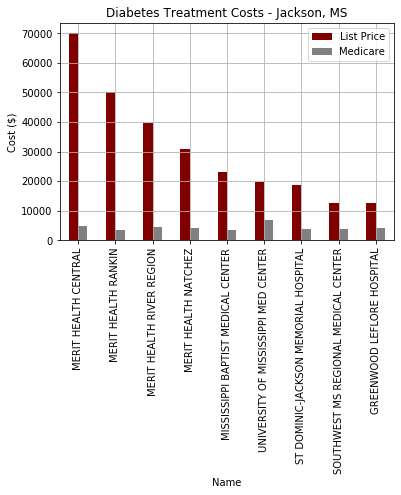

In [36]:
#Drill into Jackson, Mississippi Region - DIABETES
diabetes_jackson = diabetes_ms.loc[diabetes_ms['Region'] == 'MS - Jackson']

#Trim dataframe, plot bar graph
diabetes_j = pd.DataFrame({'List Price': (diabetes_jackson['List Price'].values),
                        'Medicare':(diabetes_jackson['Average Medicare'].values)},
                       index=diabetes_jackson['Name']).sort_values(by='List Price', ascending=False)
my_colors=('maroon', 'gray')
ax = diabetes_j.plot.bar(color = my_colors, rot=90)
plt.ylabel("Cost ($)")
plt.grid(True)
fig.tight_layout()
plt.title("Diabetes Treatment Costs - Jackson, MS")
plt.savefig('data/drg638diabetes_jackson.png')

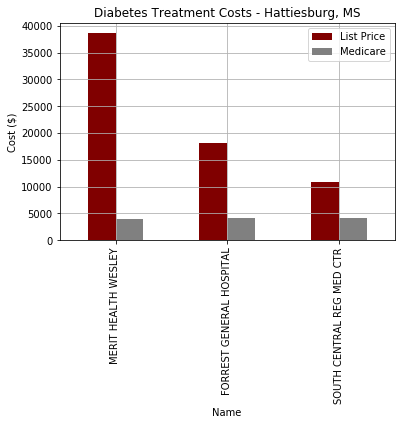

In [37]:
#Drill into Hattiesburg, Mississippi Region - DIABETES
diabetes_hattiesburg = diabetes_ms.loc[diabetes_ms['Region'] == 'MS - Hattiesburg']

#Trim dataframe, plot bar graph
diabetes_h = pd.DataFrame({'List Price': (diabetes_hattiesburg['List Price'].values),
                        'Medicare':(diabetes_hattiesburg['Average Medicare'].values)},
                       index=diabetes_hattiesburg['Name']).sort_values(by='List Price', ascending=False)
my_colors=('maroon', 'gray')
ax = diabetes_h.plot.bar(color = my_colors, rot=90)
plt.title("Diabetes Treatment Costs - Hattiesburg, MS")
plt.ylabel("Cost ($)")
plt.grid(True)
fig.tight_layout()
plt.title("Diabetes Treatment Costs - Hattiesburg, MS")
plt.savefig('data/drg638diabetes_hattiesburg.png')

In [28]:
#Drill into Mississippi - JOINTS
joint_ms = joint_master.loc[joint_master['State'] == 'MS']
joint_ms.sort_values(by='List Price', ascending=False)
#### OBSERVED - JACKSON, AND HATTIESBURG LARGE / SMALL REGIONS ARE OF INTEREST

,DRG,Provider Id,Name,Provider Street Address,City,State,Zip Code,Region,Discharges,List Price,Average Total,Average Medicare,Latitude,Longitude,Per Capita Income,Poverty Rate,Median Age
6634,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,250007,MERIT HEALTH BILOXI,150 REYNOIR STREET,BILOXI,MS,39530,MS - Gulfport,51,150442.92,15437.92,9333.02,32.7364,-89.6678,20618,21.9466,36.2
6646,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,250072,MERIT HEALTH CENTRAL,1850 CHADWICK DR,JACKSON,MS,39204,MS - Jackson,40,145655.78,12405.62,10775.62,32.7364,-89.6678,20618,21.9466,36.2
6652,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,250096,MERIT HEALTH RANKIN,350 CROSSGATES BLVD,BRANDON,MS,39042,MS - Jackson,16,131377.62,11430.38,9320.62,32.7364,-89.6678,20618,21.9466,36.2
6640,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,250042,NORTHWEST MISSISSIPPI MEDICAL CENTER,1970 HOSPITAL DRIVE,CLARKSDALE,MS,38614,TN - Memphis,14,124303.07,12791.36,11481.36,32.7364,-89.6678,20618,21.9466,36.2
6659,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,250138,MERIT HEALTH RIVER OAKS,1030 RIVER OAKS DRIVE,FLOWOOD,MS,39232,MS - Jackson,212,122952.75,13442.76,10176.91,32.7364,-89.6678,20618,21.9466,36.2
6636,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,250019,MEMORIAL HOSPITAL AT GULFPORT,4500 13TH STREET,GULFPORT,MS,39502,MS - Gulfport,231,107512.24,11987.70,8972.17,32.7364,-89.6678,20618,21.9466,36.2
6658,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,250123,GARDEN PARK MEDICAL CENTER,15200 COMMUNITY ROAD,GULFPORT,MS,39503,MS - Gulfport,112,104291.79,11661.48,8311.05,32.7364,-89.6678,20618,21.9466,36.2
6650,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,250093,BOLIVAR MEDICAL CENTER,901 E SUNFLOWER RD,CLEVELAND,MS,38732,TN - Memphis,21,103158.76,12265.52,10738.95,32.7364,-89.6678,20618,21.9466,36.2
6637,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,250031,MERIT HEALTH RIVER REGION,2100 HWY 61 N,VICKSBURG,MS,39183,MS - Jackson,37,101680.00,12049.16,10375.59,32.7364,-89.6678,20618,21.9466,36.2
6649,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,250084,MERIT HEALTH NATCHEZ,52 SERGEANT PRENTISS DRIVE,NATCHEZ,MS,39120,MS - Jackson,26,99335.04,12609.19,10774.81,32.7364,-89.6678,20618,21.9466,36.2


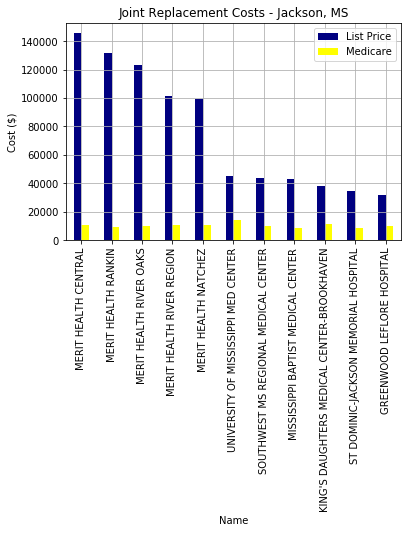

In [38]:
#Drill into Jackson, Mississippi Region - JOINT
joint_jackson = joint_ms.loc[joint_ms['Region'] == 'MS - Jackson']
joint_jackson.sort_values(by='List Price', ascending=False)

#Trim dataframe, plot bar graph
joint_j = pd.DataFrame({'List Price': (joint_jackson['List Price'].values),
                        'Medicare':(joint_jackson['Average Medicare'].values)},
                       index=joint_jackson['Name']).sort_values(by='List Price', ascending=False)
my_colors=('navy', 'yellow')
ax = joint_j.plot.bar(color = my_colors, rot=90)
plt.title("Joint Replacement Costs - Jackson, MS")
plt.ylabel("Cost ($)")
plt.grid(True)
fig.tight_layout()
plt.savefig('data/drg470joint_jacksonville.png')

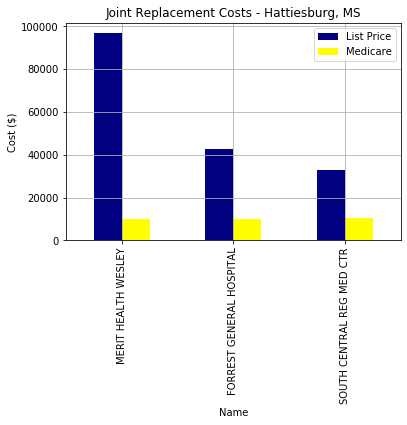

In [39]:
#Drill into Gulfport, Mississippi Region - JOINT
joint_hattiesburg = joint_ms.loc[joint_ms['Region'] == 'MS - Hattiesburg']
joint_hattiesburg.sort_values(by='List Price', ascending=False)

#Trim dataframe, plot bar graph
joint_h = pd.DataFrame({'List Price': (joint_hattiesburg['List Price'].values),
                        'Medicare':(joint_hattiesburg['Average Medicare'].values)},
                       index=joint_hattiesburg['Name']).sort_values(by='List Price', ascending=False)
my_colors=('navy', 'yellow')
ax = joint_h.plot.bar(color = my_colors, rot=90)
plt.title("Joint Replacement Costs - Hattiesburg, MS")
plt.ylabel("Cost ($)")
plt.grid(True)
fig.tight_layout()
plt.savefig('data/drg470joint_hattiesburg.png')

In [50]:
#Read in joint and diabetes datasets with ratings.
joint_ratings_master = pd.read_csv('data/charge_survey_JOINT_LEFT_Mrgdata.csv')
diabetes_ratings_master = pd.read_csv('data/charge_survey_DIABETES_LEFT_Mrgdata.csv')

joint_ratings = joint_ratings_master.drop(['Readmission national comparison footnote', 'Patient experience national comparison footnote',
                                           'Effectiveness of care national comparison footnote','Timeliness of care national comparison footnote',
                                           'Efficient use of medical imaging national comparison footnote',
                                           'Hospital overall rating footnote','Mortality national comparison footnote',
                                           'Safety of care national comparison footnote'],axis=1)
diabetes_ratings = diabetes_ratings_master.drop(['Readmission national comparison footnote', 'Patient experience national comparison footnote',
                                           'Effectiveness of care national comparison footnote','Timeliness of care national comparison footnote',
                                           'Efficient use of medical imaging national comparison footnote',
                                           'Hospital overall rating footnote','Mortality national comparison footnote',
                                           'Safety of care national comparison footnote'],axis=1)
diabetes_ratings.head(1)

,DRG Definition,Provider ID,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region (HRR) Description,Total Discharges,Average Covered Charges,...,Emergency Services,Meets criteria for meaningful use of EHRs,Hospital overall rating,Mortality national comparison,Safety of care national comparison,Readmission national comparison,Patient experience national comparison,Effectiveness of care national comparison,Timeliness of care national comparison,Efficient use of medical imaging national comparison
0,638 - DIABETES W CC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,46,22621.0,...,Yes,Y,3,Same as the national average,Above the national average,Below the national average,Below the national average,Same as the national average,Same as the national average,Same as the national average


In [228]:
#Enumerate the comparable ratings: 3, 2, 1
diabetes_ratings = diabetes_ratings.replace(['Above the national average'],3)
diabetes_ratings = diabetes_ratings.replace(['Same as the national average'], 2)
diabetes_ratings = diabetes_ratings.replace(['Below the national average'], 1)

joint_ratings = joint_ratings.replace(['Above the national average'], '3')
joint_ratings = joint_ratings.replace(['Same as the national average'], '2')
joint_ratings = joint_ratings.replace(['Below the national average'], '1')

#Convert to numeric
diabetes_ratings['Mortality national comparison'] = pd.to_numeric(diabetes_ratings['Mortality national comparison'],errors='coerce')
diabetes_ratings['Safety of care national comparison'] = pd.to_numeric(diabetes_ratings['Safety of care national comparison'],errors='coerce')
diabetes_ratings['Readmission national comparison'] = pd.to_numeric(diabetes_ratings['Readmission national comparison'],errors='coerce')
diabetes_ratings['Patient experience national comparison'] = pd.to_numeric(diabetes_ratings['Patient experience national comparison'],errors='coerce')
diabetes_ratings['Effectiveness of care national comparison'] = pd.to_numeric(diabetes_ratings['Effectiveness of care national comparison'],errors='coerce')
diabetes_ratings['Timeliness of care national comparison'] = pd.to_numeric(diabetes_ratings['Timeliness of care national comparison'],errors='coerce')
diabetes_ratings['Efficient use of medical imaging national comparison'] = pd.to_numeric(diabetes_ratings['Efficient use of medical imaging national comparison'],errors='coerce')
diabetes_ratings['Hospital overall rating'] = pd.to_numeric(diabetes_ratings['Hospital overall rating'],errors='coerce')

joint_ratings['Mortality national comparison'] = pd.to_numeric(joint_ratings['Mortality national comparison'],errors='coerce')
joint_ratings['Safety of care national comparison'] = pd.to_numeric(joint_ratings['Safety of care national comparison'],errors='coerce')
joint_ratings['Readmission national comparison'] = pd.to_numeric(joint_ratings['Readmission national comparison'],errors='coerce')
joint_ratings['Patient experience national comparison'] = pd.to_numeric(joint_ratings['Patient experience national comparison'],errors='coerce')
joint_ratings['Effectiveness of care national comparison'] = pd.to_numeric(joint_ratings['Effectiveness of care national comparison'],errors='coerce')
joint_ratings['Timeliness of care national comparison'] = pd.to_numeric(joint_ratings['Timeliness of care national comparison'],errors='coerce')
joint_ratings['Efficient use of medical imaging national comparison'] = pd.to_numeric(joint_ratings['Efficient use of medical imaging national comparison'],errors='coerce')
joint_ratings['Hospital overall rating'] = pd.to_numeric(joint_ratings['Hospital overall rating'],errors='coerce')

joint_ratings.to_csv('joint_numeric.csv',encoding='utf-8')
diabetes_ratings.to_csv('diabetes_numeric.csv',encoding='utf-8')

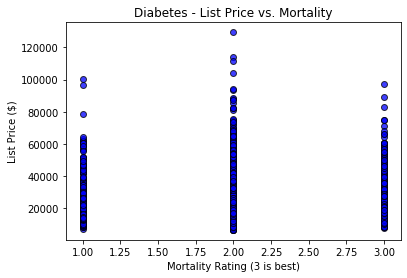

In [97]:
# Diabetes - Create Matplotlib scatter based on List Price vs. Comps
plt.title("Diabetes - List Price vs. Mortality")
plt.xlabel('Mortality Rating (3 is best)')
plt.ylabel('List Price ($)')
plt.scatter(diabetes_ratings['Mortality national comparison'],diabetes_ratings['Average Covered Charges'], marker="o", facecolors="blue", edgecolors="black",alpha=0.75)
#plt.scatter(diabetes_ratings['Hospital overall rating'],diabetes_ratings['Average Covered Charges'], marker="o", facecolors="yellow", edgecolors="black",alpha=0.75)

plt.savefig('diabetes_ratings_mortality.png')

In [224]:
avg_list_price =[]
hospital_rating = []
params = ['Mortality', 'Safety of care', 'Readmission', 'Patient experience', 'Effectiveness of care',
          'Timeliness of care','Efficient use of medical imaging']
comp_df = pd.DataFrame(columns=[params])


#loop through ratings, calculate 
for i in range (1,4):
    for x in params:
        diabetes_rated = diabetes_ratings.loc[diabetes_ratings[f'{x} national comparison'] == i]
        y = diabetes_rated ['Average Covered Charges'].mean()
        comp_df.at[i,x] = y
comp_df['Rating']=([1,2,3])
comp_df.head()

,Mortality,Safety of care,Readmission,Patient experience,Effectiveness of care,Timeliness of care,Efficient use of medical imaging,Rating
1,26109.5,29319.3,29992.9,31717,28821.5,30594.6,27369.9,1
2,27798.6,25805.7,26752,25265.4,27794,26097.2,27867.4,2
3,29661.9,27534.2,25699.7,23814.3,27058.7,24330.3,27766.4,3


TypeError: only integer scalar arrays can be converted to a scalar index

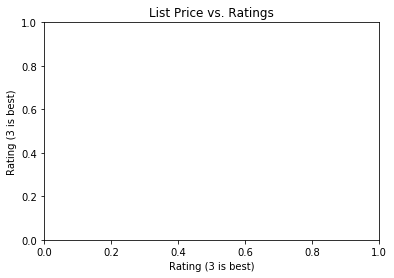

In [218]:
# Diabetes - Create Matplotlib scatter based on List Price vs. Comps
plt.title('List Price vs. Ratings')
plt.xlabel('Rating (3 is best)')
plt.ylabel('Rating (3 is best)')
plt.plot(comp_df['Rating'].asint,comp_df['Mortality'], marker="o", facecolors="blue", edgecolors="black",alpha=0.75)


#t.savefig('diabetes_ratings_mortality.png')